In [1]:
import pandas as pd
import urllib
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

# <center>Tarea 3 Máquinas de Aprendizaje</center>

<center>
Patricio Horth M.<br>
Víctor Zúñiga M.<br>

22 de Diciembre de 2017
</center>



# Introducción

Este trabajo tratará sobre la generación de modelos de clasificación no lineales

# 1. Small Circle inside Large Circle

In [2]:
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
    np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),
    np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [3]:
import matplotlib.pyplot as plt
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(12, 8))
    axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap='cool')
    axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0
    axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"],
    levels=[-2, 0, 2])
    plt.show()

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
n_h=1
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(n_h, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=50, batch_size=100, verbose=1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

Using TensorFlow backend.


NameError: name 'X_train' is not defined

# 2. Bike Sharing

En la siguiente sección se probarán varias técnicas para resolver el problema de *Bike Sharing Demand* de *Kaggle* usando un subconjunto de los datos originales para entrenamiento, validación y prueba. Aquí se busca predecir una demanda, la cual será representada como un número entero en la variable *count*.

## a) Ingreso y análisis descriptivo de los datos

In [2]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print('\nSummary - dataframe completo:\n')

print(df.describe())



Summary - dataframe completo:

         Unnamed: 0        season       holiday    workingday       weather  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean    5442.500000      2.506614      0.028569      0.680875      1.418427   
std     3142.661849      1.116174      0.166599      0.466159      0.633839   
min        0.000000      1.000000      0.000000      0.000000      1.000000   
25%     2721.250000      2.000000      0.000000      0.000000      1.000000   
50%     5442.500000      3.000000      0.000000      1.000000      1.000000   
75%     8163.750000      4.000000      0.000000      1.000000      2.000000   
max    10885.000000      4.000000      1.000000      1.000000      4.000000   

              temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159    

In [3]:
df.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3


In [4]:
df['datetime']

0       2011-01-01 03:00:00
1       2011-01-01 04:00:00
2       2011-01-01 05:00:00
3       2011-01-01 06:00:00
4       2011-01-01 07:00:00
5       2011-01-01 09:00:00
6       2011-01-01 14:00:00
7       2011-01-01 16:00:00
8       2011-01-01 17:00:00
9       2011-01-01 18:00:00
10      2011-01-01 19:00:00
11      2011-01-01 20:00:00
12      2011-01-02 00:00:00
13      2011-01-02 01:00:00
14      2011-01-02 02:00:00
15      2011-01-02 04:00:00
16      2011-01-02 06:00:00
17      2011-01-02 07:00:00
18      2011-01-02 10:00:00
19      2011-01-02 12:00:00
20      2011-01-02 13:00:00
21      2011-01-02 14:00:00
22      2011-01-02 15:00:00
23      2011-01-02 18:00:00
24      2011-01-02 19:00:00
25      2011-01-02 20:00:00
26      2011-01-02 21:00:00
27      2011-01-02 23:00:00
28      2011-01-03 04:00:00
29      2011-01-03 05:00:00
               ...         
2117    2012-12-12 19:00:00
2118    2012-12-13 13:00:00
2119    2012-12-13 16:00:00
2120    2012-12-13 19:00:00
2121    2012-12-14 0

Podemos notar que la columna *datetime* incluye datos de fecha y hora, los cuales pueden ser muy útiles, pero no podrán ser tratados con el formato actual.

Por ahora, asumiremos que el dato más importante a partir de *datetime* será la hora, por lo que crearemos una nueva característica *hour* a partir de ésta, y se dejará de lado *datetime*.

In [5]:
# Creamos una nueva columna "hora" u "hour" a partir de la columna string "datetime"

df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


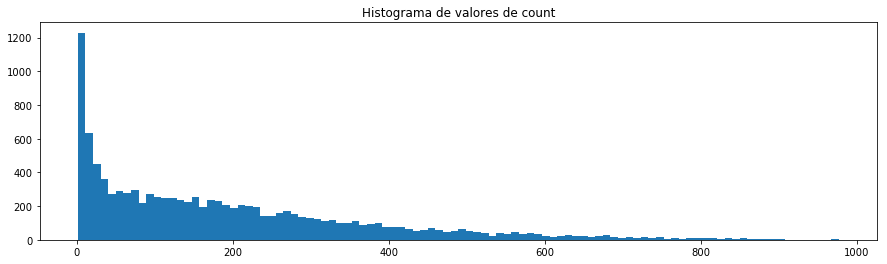

In [6]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de count")
#plt.xticks(range(1,12))
plt.hist(df['count'],bins=100)
plt.show()

## b) Predicción de demanda mediante Árbol de Regresión

In [8]:
def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_log(y_predict,y_true):
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG VAL TRAIN =0.554511
KAGG EVAL TEST =0.574239


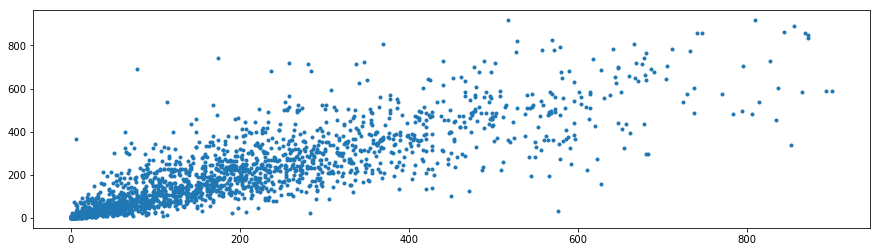

In [8]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt


Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG VAL TRAIN =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

## c) Sintonización de parámetros para el Árbol de Regresión

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)


parameters = {'random_state' : [0], 'max_depth':range(2,30), 'min_samples_split': range(2,30), 'min_samples_leaf': range(1,30) }
clf = GridSearchCV(Tree(), parameters, scoring= make_scorer(eval_bikemodel, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = clf.best_estimator_.predict(X_val)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val)

0.711209079858
KAGG EVAL VAL =0.554511


KeyboardInterrupt: 

In [9]:
# ARBOL POR DEFECTO
model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# ARBOL MAS MALO POSIBLE
model = Tree(max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 14, min_samples_leaf= 12, min_samples_split= 2, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

0.711209079858
KAGG EVAL VAL =0.554511
0.389400784751
KAGG EVAL VAL =0.896665
0.792735149763
KAGG EVAL VAL =0.479710
0.792968373194
KAGG EVAL VAL =0.477732


In [10]:
# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

En conjunto de Validación
0.792968373194
KAGG EVAL VAL =0.477732
En conjunto de Prueba
0.789548859854
KAGG EVAL VAL =0.520036


## d) Preprocesamiento de los datos

Hemos llegado a un resultado mejor que antes, pero aún insuficiente. Hay dos puntos que será necesario tomar en cuenta si se quiere mejorar el puntaje:

* Hacer transaformaciones sobre los datos, con tal de que los algoritmos se comporten mejor
* Utilizar alguno de los datos de la columna *datetime* que fueron ignorados anteriormente

Para el primer punto, volveremos al histograma de la variable objetivo *count* que realizamos anteriormente.

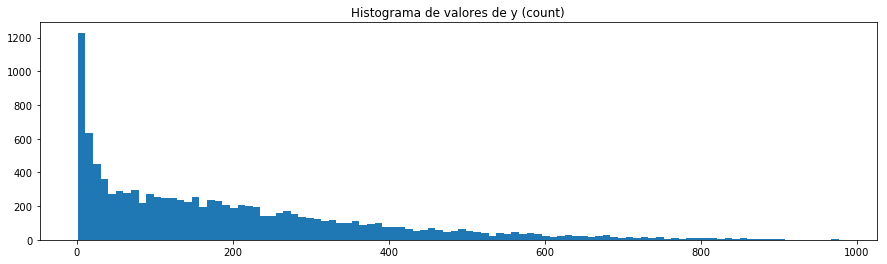

In [11]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de y (count)")
#plt.xticks(range(1,12))
plt.hist(df['count'],bins=100)
plt.show()

Vemos que existen muchos datos con valores bajos: la variable tiene "*skewness*" hacia la izquierda. Con tal de buscar que los datos se comporten en forma cercana a una distribución normal, se probarán varias transformaciones:

* Transformación logarítmica
* Transformación *square root* o raíz cuadrada
* Transformación logarítmica elevada al cuadrado
* Transformación Box-Cox

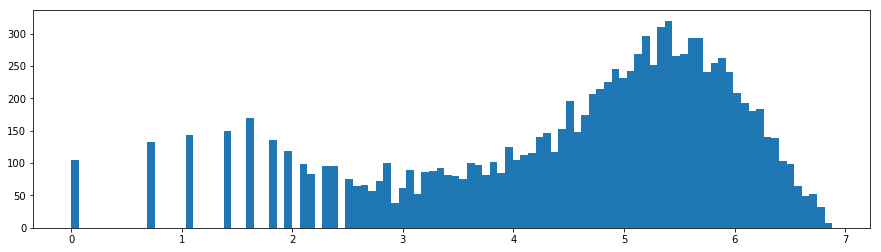

In [12]:
plt.hist((np.log(df['count'])),bins=100)
plt.show()

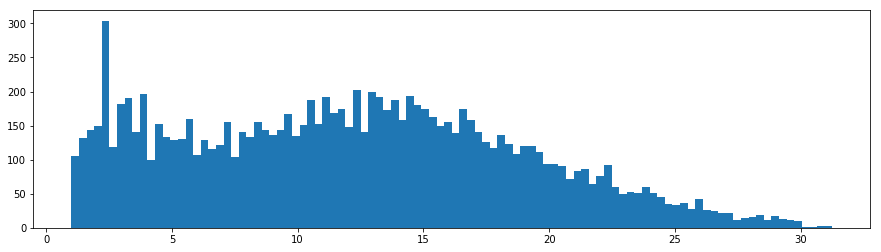

In [13]:
plt.hist((np.sqrt(df['count'])),bins=100)
plt.show()

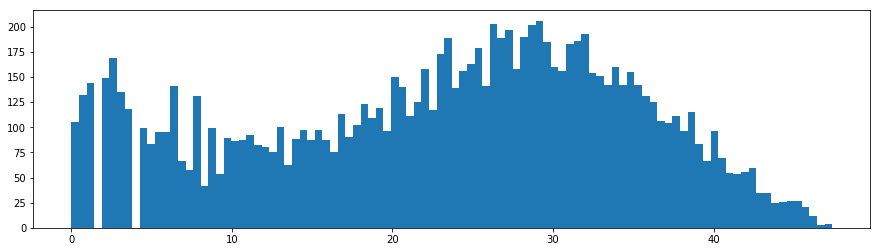

In [14]:
plt.hist((np.log(df['count'])**2),bins=100)
plt.show()

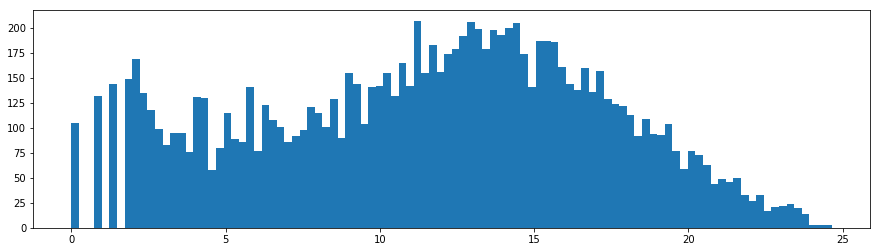

In [15]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.hist(boxcox(df['count'])[0],bins=100)
plt.show()

Para el segundo punto, se utilizará no sólo la hora, si no también el día de la semana desde la columna *datetime*.

A continuación se probarán varias de estas transformaciones, junto con la columna nueva.

In [16]:
from sklearn.preprocessing import StandardScaler

df = pd.concat([dftrain,dfval,dftest])

# Creamos una nueva columna "hora" u "hour" a partir de la columna string "datetime"
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

# Creamos una nueva columna "dias de la semana" o "cday" a partir de la columna string "datetime"
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek #0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])

#print(df['cday'])

Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]
#Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
#Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]


# Aplicando logaritmo a Y, ademas hay que cambiar eval_bikemodel

Ydf=df.loc[:,'count']


#Y_std = boxcox(Ydf)[0]

#Y_std = (np.log(Ydf))**2
#Y_std = Ydf

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_log(y_predict,y_true):
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_sqrt(y_predict,y_true):
    diff = np.log(y_predict**2+1.0) - np.log(y_true**2+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_logsquared(y_predict,y_true):
    diff = np.log(np.exp(np.sqrt(y_predict))+1.0) - np.log(np.exp(np.sqrt(y_true))+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_boxcox(y_predict,y_true):
    diff = (inv_boxcox(y_predict)+1.0) - (inv_boxcox(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Scaler_X = StandardScaler().fit(Xdf)
X_std = Scaler_X.transform(Xdf)

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]

SCORE TEST=0.822589
KAGG EVAL TRAIN =0.010646
KAGG EVAL VAL =0.539489
KAGG EVAL TEST =0.578443


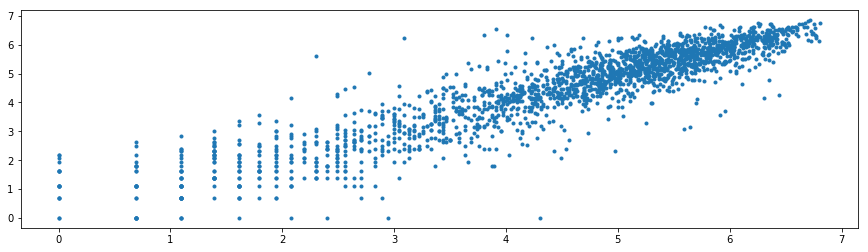

In [17]:
# Prueba 1, con log

Y_std = np.log(Ydf)
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_log(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_log(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

SCORE TEST=0.793169
KAGG EVAL TRAIN =0.010671
KAGG EVAL VAL =0.538698
KAGG EVAL TEST =0.554717


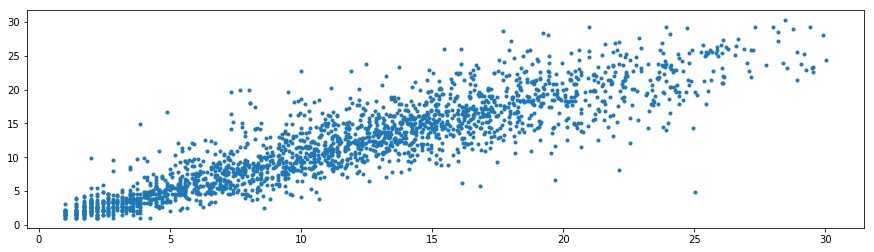

In [18]:
# Prueba 2, con sqrt

Y_std = np.sqrt(Ydf)
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_sqrt(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_sqrt(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_sqrt(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

SCORE TEST=0.822179
KAGG EVAL TRAIN =0.010653
KAGG EVAL VAL =0.544672
KAGG EVAL TEST =0.571342


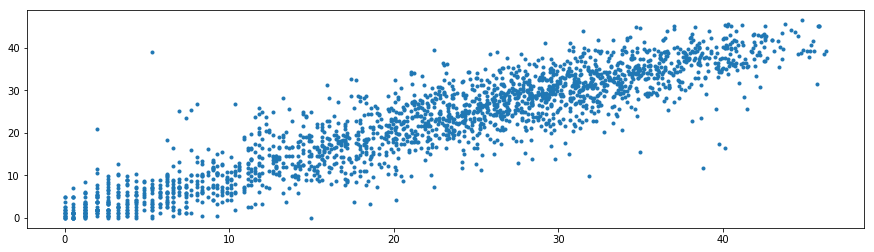

In [19]:
# Prueba 3, con logsquared

Y_std = (np.log(Ydf))**2
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_logsquared(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_logsquared(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_logsquared(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

In [20]:
# Prueba 4, con boxcox

Y_std = Y_std = boxcox(Ydf)[0]
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_boxcox(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_boxcox(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_boxcox(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

SCORE TEST=0.809350


ValueError: invalid number of arguments

In [21]:
Y_std = np.log(Ydf)
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 14, min_samples_leaf= 12, min_samples_split= 2, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

0.889173312323
KAGG EVAL VAL =0.466043
0.888551210534
KAGG EVAL VAL =0.467601


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)


parameters = {'random_state' : [0], 'max_depth':range(2,30), 'min_samples_split': range(2,30), 'min_samples_leaf': range(1,30) }
clf = GridSearchCV(Tree(), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = clf.best_estimator_.predict(X_val)

kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val)

0.850732139872
KAGG EVAL VAL =0.539489


KeyboardInterrupt: 

In [23]:
# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 3, min_samples_split= 18, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print(" En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("\n En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

 En conjunto de Validación
0.892357824533
KAGG EVAL VAL =0.458207

 En conjunto de Prueba
0.875143246149
KAGG EVAL VAL =0.486905


## e) Predicción de Demanda mediante SVM

In [9]:
#load dataframes as before ...
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour','cday']]

# Transformacion a vectores binarios
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday'])

# Y
Ydf=df.loc[:,'count']
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

# X
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X_std = scalerX.fit_transform(Xdf)

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]


from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.302102748577
KAGG EVAL VAL =0.966316


Vemos que se obtuvo un puntaje bastante malo. ¿Por qué? No se ha hecho la transformación logarítmica. Aplicando ésta, obtendremos lo siguiente:

In [11]:
# Y
Ydf=np.log(df.loc[:,'count'])
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.916631380463
KAGG EVAL VAL =0.399695


Logramos obtener un desempeño mucho mejor que con el árbol de clasificación. Vale mencionar que el tiempo de computación fue mucho mayor, por lo que en ciertas circunstancias podría no ser conveniente.

## f) Sintonización de Parámetros de SVM

Si bien logramos un buen resultado usando SVM con los parámetros por defecto (Kernel Gaussiano, $C=1$, epsilon igual a $0.1$), se podrían ajustar estos parámetros para obtener un mejor rendimiento.

Primero, se hará un Grid Search con Cross Validation en el conjunto de entrenamiento, probando con valores de C entre $10^-2$ y $10^2$, utilizando dos kernels distintos: lineal y gaussiano.

Luego, utilizando los parámetros anteriores, se probará con diferentes valores de *epsilon*.

Sería mejor hacer de una sola vez un Grid Search con los tres parámetros, y poder probar con otros Kernels, pero el costo computacional va a ser excesivo, por lo que los haremos por separado.

In [26]:
def eval_bikemodel_log(y_predict,y_true):
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_log(y_predict,y_true):
    diff = np.log((1.0 + np.exp(y_predict)) / (1.0 + np.exp(y_true)))
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

#parameters = {'C':range(1,10), 'epsilon': [0.1, 0.3, 0.5, 0.7, 1, 1.3], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
parameters = {'C':np.logspace(-2, 2, 5), 'kernel': ['linear', 'rbf'] }
#parameters = {'C': [1, 10]}
clf = GridSearchCV(SVR(verbose=1), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False), cv=2)
clf.fit(X_train,Y_train)
model = clf.best_estimator_
print ("Los mejores parametros son: ", clf.best_params_) 

Y_pred_val = model.predict(X_val)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

parameters = {'epsilon': np.logspace(-3, 3, 5) }
clf = GridSearchCV(SVR(verbose=1, C=1, kernel='rbf'), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False), cv=2)
clf.fit(X_train,Y_train)
model = clf.best_estimator_
print ("Los mejores parametros son: ", clf.best_params_) 

Y_pred_val = model.predict(X_val)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

[LibSVM][LibSVM]

KeyboardInterrupt: 

Finalmente se obtiene que el mejor valor de C es el que está por defecto, o sea, 1, junto con el uso de un Kernel Gaussiano. Con objetivo de demostración, a continuación se van a comparar los puntajes obtenidos por una SVM lineal con una SVM Gaussiana.

In [25]:
model = SVR(C=1, kernel='linear')
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

En conjunto de Validación
0.789770560792
KAGG EVAL VAL =0.647314
En conjunto de Prueba
0.774659081829
KAGG EVAL VAL =0.659751


In [26]:
model = SVR(C=1, kernel='rbf')
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

En conjunto de Validación
0.916631380463
KAGG EVAL VAL =0.399695
En conjunto de Prueba
0.9061060821
KAGG EVAL VAL =0.420003


## g) Prueba utilizando conjunto de validación para entrenamiento, y sintonización con Cross Validation con K=10

A continuación se hará una prueba utilizando el conjunto de validación como conjunto de entrenamiento. Además, el nuevo modelo será definido por nuevos hiperparámetros obtenidos mediante Grid Search con Cross Validation de $K=10$ *folds*.

Como parámetros de la SVM, se usará siempre el Kernel Gaussiano, se variará C entre $10^{-2}$ y $10^2$, y se variará *gamma* entre $10^{-5}$ y $10^{2}$

In [28]:
model = SVR(C=1, kernel='rbf') # Parametros por defecto
model.fit(X_val,Y_val) # Se usa conj de validacion para entrenar
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val) 

En conjunto de Validación
0.947751673108
KAGG EVAL VAL =0.311170
En conjunto de Prueba
0.891073266416
KAGG TEST VAL =0.451223


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

# Probaremos con
# C = 10**-2, 10**-1, ... , 10**2
# gamma = 10**-5, 10**-1, ... , 10**2

parameters = {'C': np.logspace(-2, 2, 5), 'gamma': np.logspace(-2, 2, 5) }
clf = GridSearchCV(SVR(), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False), cv=10)
clf.fit(X_val,Y_val)
model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val) 

-0.532374646819 {'C': 10.0, 'gamma': 0.01}
En conjunto de Validación
0.963456223862
KAGG EVAL VAL =0.261905
En conjunto de Prueba
0.897137292221
KAGG TEST VAL =0.440108


In [32]:
model = SVR(C=10, gamma= 0.01, kernel='rbf') # Parametros por defecto
model.fit(X_val,Y_val) # Se usa conj de validacion para entrenar
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val)

En conjunto de Validación
0.963456223862
KAGG EVAL VAL =0.261905
En conjunto de Prueba
0.897137292221
KAGG TEST VAL =0.440108


In [34]:
np.logspace(-9, 3, 13)

array([  1.00000000e-09,   1.00000000e-08,   1.00000000e-07,
         1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03])

In [39]:
np.logspace(-3, 3, 7)

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03])